In [7]:
import os
import json
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from openai import OpenAI

client = OpenAI(
    base_url="https://api.chatanywhere.tech/v1"
)

def chat(says):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": says,
            }
        ],
        model="gpt-4o-2024-05-13",
    )
    print("bots: "+chat_completion.choices[0].message.content)
    return  chat_completion.choices[0].message.content

def obj(x,y):
    return (x-2)**2+(y-3)**2

with open("prompt.txt","r",encoding="utf-8") as file:
    says = file.read()

def Getvalue(ch,str):
    s = str.find(ch)
    e = str[s+1:].find(ch)
    return str[s+1:s+e+1]

def warm_strat(num):
    flag  = 1 #Determine whether the output meets the format.
    while flag:
        pt = (
            "You need to assume {} initial points for an optimization problem, and the objective function corresponding to the initial points should be as small as possible."
            "The objective function of this task is a binary quadratic function."
            "x1 must be within the range of [-5, 5]. x2 must be within the range of [-5, 5]."
            "According to the experience of previous tasks, the minimum value of the objective function may be around x1, x2 = 3, 3."
            "Please do not provide duplicate values."
            "Please give your answer and format your output as follows: *[],[],[],...,[]*").format(num)
        datas = Getvalue("*",chat(pt))
        datas = "[" + datas + "]"
        try:
            datas =  ast.literal_eval(datas)
        except Exception as e:
            continue
        if len(datas) == num:
            flag = 0
    return datas

def candidate_sampling(history,num):
    flag  = 1 #Determine whether the output meets the format.
    while flag:
        pt = (
            "Based on the previous optimization results {}, you need to provide {} candidate points for the next optimization."
            "The objective function of this task is a binary quadratic function."
            "x1 must be within the range of [-5, 5]. x2 must be within the range of [-5, 5]."
            "Please do not provide duplicate values."
            "Please give your answer and format your output as follows: *[],[],[],...,[]*").format(json.dumps(history),num)
        datas = Getvalue("*",chat(pt))
        datas = "[" + datas + "]"
        try:
            datas =  ast.literal_eval(datas)
        except Exception as e:
            continue
        if len(datas) == num:
            flag = 0
    return datas

agent_prompts = {
    "optimistic": "You are an optimistic agent. Inclined to explore uncertainties.",
    "pessimistic": "You are a pessimistic agent. Inclined to avoid risks.",
    "Conservative": "You are a conservative agent. You weigh the pros and cons to make decisions.",
}
def AcquisitionFunction(history,pred):
    
    m = 2
    inipt = ("{}"
            "You need to reasonably select the most potential parameters from the predicted data table based on your own experience and historical data tables for the next optimization step."
            "We hope you can balance the relationship between exploration and exploitation to achieve the best results."
            "The following is a historical data table, with format [Hyperparameters] - [loss]:"
            "{}"
            "The following is a predicted data table, with format [Hyperparameters] - [predloss]:"
            "{}"
            "A brief summary of your reasons, as concise as possible."
            "Please provide 2 sets of parameter combinations that you consider optimal, in the format *[],[]*")
    res = {"optimistic":"","Conservative":"","pessimistic":""}
    datas = []
    for i in agent_prompts.keys():
        flag  = 1 #Determine whether the output meets the format.
        while flag:
            pt = inipt.format(agent_prompts[i],json.dumps(history),json.dumps(pred))
            res[i] = chat(pt)
            str = Getvalue("*",res[i])
            str = "[" + str + "]"
            try:
                data =  ast.literal_eval(str)
            except Exception as e:
                continue
            if len(data) == 2:
                datas.append(data)
                flag = 0
                
    pt = ("{}"
            "The parameter combination chosen by the three of you is: "
            "{}"
            "The reasons for the choices made by the other two are: "
            "{} and {}"
            "A brief summary of your reasons, as concise as possible."
            "Please select one best parameter combination from those chosen by everyone, in the format *[]*")
    keys = list(agent_prompts.keys())
    for i in range(m):
        for index, key in enumerate(agent_prompts.keys()):
            flag  = 1 #Determine whether the output meets the format.
            while flag:
                pt = pt.format(agent_prompts[key],datas,res[keys[(index+1)%3]],res[keys[(index+2)%3]])
                print(pt)
                res[i] = chat(pt)
                str = Getvalue("*",res[i])
                str = "[" + str + "]"
                try:
                    data =  ast.literal_eval(str)
                except Exception as e:
                    continue
                if len(data) == 1:
                    flag = 0
    return data[0]

#AcquisitionFunction([{"params": [0, 0], "loss": 13}], [{"params": [1, 1], "loss": 10},{"params": [2, 1], "loss": 8},{"params": [2, 2], "loss": 6},{"params": [2, 3], "loss": 0}])

def SurrogateModel(history,samples):
    data_pred = []
    for i in range(len(samples)):
        flag  = 1 #Determine whether the output meets the format.
        while flag:
            pt = ("You are helping tune hyperparameters to minimize loss(>0)."
                "The objective function of this task is a binary quadratic function."
                "You need to guess the target function value for a given x based on historical evaluation data."
                "Below is the historical evaluation data, formatted as [Hyperparameters] - [loss]:"
                "{}"
                "As short as possible, do not provide too much information."
                "Please guess the loss for params:{} and format your output as follows: *xx*").format(history,samples[i])
            loss = re.findall(r'-?\d+\.\d+|-?\d+', Getvalue("*",chat(pt)))
            if len(loss) == 1:
                flag = 0
                new_entry = {"params": samples[i], "loss": float(loss[0])}
                data_pred.append(new_entry)
    return data_pred

In [19]:
 ### config
numiters = 10        # number of iters for BO
numinipoint = 3      # number of ini points
numsamples = 5       # number of sampled points

### initial
inidatas = warm_strat(numinipoint)
datas = []
arrloss = [1e6]
for i in inidatas:
    loss = obj(i[0],i[1])
    new_entry = {"params": [i[0], i[1]], "loss": loss}
    arrloss[0] = min(arrloss[0],loss)
    datas.append(new_entry)

bots: *[3, 3], [2, 4], [4, 2]*


In [20]:
### Optimization   
for i in tqdm(range(numiters)):
    samplers = candidate_sampling(datas,numsamples)
    data_pred = SurrogateModel(datas,samplers)
    next_point = min(data_pred, key=lambda x: x['loss'])
    loss = obj(next_point["params"][0],next_point["params"][1])
    arrloss.append(loss)
    new_entry = {"params": next_point["params"], "loss": loss} 
    datas.append(new_entry)

  0%|          | 0/10 [00:00<?, ?it/s]

bots: *[1, 5], [-4, -1], [0, 0], [5, -3], [-2, 2]*
bots: *3*
bots: *81*
bots: *0*
bots: *13*


 10%|█         | 1/10 [00:04<00:42,  4.78s/it]

bots: *1*
bots: *[1, 5], [5, 1], [0, 2], [-2, 3], [-1, 4]*
bots: *5*
bots: *25*
bots: *5*
bots: *25*


 20%|██        | 2/10 [00:09<00:36,  4.59s/it]

bots: *25*
bots: Based on the given optimization results and the objective function being a binary quadratic function, here are the 5 candidate points for the next optimization:

*[3, 2], [2, 3], [1, 4], [4, 1], [0, 1]*
bots: *3*
bots: *1*
bots: *1*
bots: *9*


 30%|███       | 3/10 [00:13<00:31,  4.57s/it]

bots: *16*
bots: Based on the previous optimization results and considering the objective function is a binary quadratic function, we have to find candidate points which might give better (lower) loss values. Considering the previous outcomes, it seems that [2, 3] was the best point (with loss 0), and other close points also yielded relatively low losses. 

Therefore, let's generate some candidate points considering various combinations around the successful region:

*[2, 2], [3, 2], [1, 3], [1, 2], [2, 4]*
bots: *1*
bots: *2*
bots: *1*
bots: *5*


 40%|████      | 4/10 [00:19<00:29,  4.95s/it]

bots: *1*
bots: Here are five candidate points for the next optimization:

*[-1, 3], [3, 1], [1, 2], [2, 1], [-2, 3]*
bots: *5*
bots: *5*
bots: *4*
bots: *4*


 50%|█████     | 5/10 [00:24<00:24,  4.87s/it]

bots: *25*
bots: Given the previous optimization results and aiming to find new points that explore the space without duplicating past evaluations, the next candidate points for the optimization can be chosen considering the range [-5, 5] for both x1 and x2. Let’s also ensure these points are not duplicates and are somewhat dispersed to cover the space better.

Here are the 5 candidate points:

*[[-1, 3], [3, -2], [0, 4], [-3, -1], [4, 1]]*

These points should provide a good exploration of the parameter space given the binary quadratic function's nature and past results.
bots: Based on the previous optimization results and considering the objective function is a binary quadratic function, here are five candidate points for the next optimization:

*[2, 3], [2, 1], [3, 2], [1, 3], [3, 1]*
bots: *0*
bots: *1*
bots: *2*
bots: *0*


 60%|██████    | 6/10 [00:31<00:22,  5.69s/it]

bots: *4*
bots: Based on the previous optimization results and the requirement for unique candidate points, here are 5 new points for the next optimization:

*[-4, 4], [3, 2], [1, 4], [0, 3], [-1, 1]*
bots: *41*
bots: *5*
bots: *3*
bots: *6*


 70%|███████   | 7/10 [00:36<00:16,  5.43s/it]

bots: *10*
bots: Based on the previous optimization results, it appears that the optimal region could be around `[2, 3]` since it has the lowest loss value of `0`. Given the objective is a binary quadratic function and working within the specified range of `[-5, 5]` for both `x1` and `x2`, we should generate candidate points around the previously successful regions but avoiding duplication.

Here are the 5 candidate points for the next optimization:

*[2, 3.5], [1.5, 3], [2, 2.5], [1.8, 3.2], [2.2, 3]*
bots: *0*
bots: *1*
bots: *0.5*
bots: *0*


 80%|████████  | 8/10 [00:44<00:12,  6.24s/it]

bots: *0*
bots: Here are 5 candidate points for the next optimization:

*[2.1, 3], [2, 3.2], [2, 3.3], [2.2, 3], [2, 3.4]*
bots: *0.01*
bots: *0.04*
bots: *0.1*
bots: *0.04*


 90%|█████████ | 9/10 [00:51<00:06,  6.43s/it]

bots: *0.16*
bots: * [2.05, 3]
* [2.1, 2.95]
* [2, 3.25]
* [2.15, 3]
* [1.95, 3]
bots: *[2.1, 2.9], [2.2, 3], [2, 2.8], [2.1, 3.1], [1.9, 3]*
bots: *0.02*
bots: *0.04*
bots: *0.64*
bots: *0.02*


100%|██████████| 10/10 [00:57<00:00,  5.75s/it]

bots: *0.010000000000000018*


[{'params': [3, 3], 'loss': 1}, {'params': [2, 4], 'loss': 1}, {'params': [4, 2], 'loss': 5}, {'params': [0, 0], 'loss': 13}, {'params': [1, 5], 'loss': 5}, {'params': [2, 3], 'loss': 0}, {'params': [2, 2], 'loss': 1}, {'params': [1, 2], 'loss': 2}, {'params': [2, 3], 'loss': 0}, {'params': [1, 4], 'loss': 2}, {'params': [2, 3.5], 'loss': 0.25}, {'params': [2.1, 3], 'loss': 0.010000000000000018}, {'params': [1.9, 3], 'loss': 0.010000000000000018}]


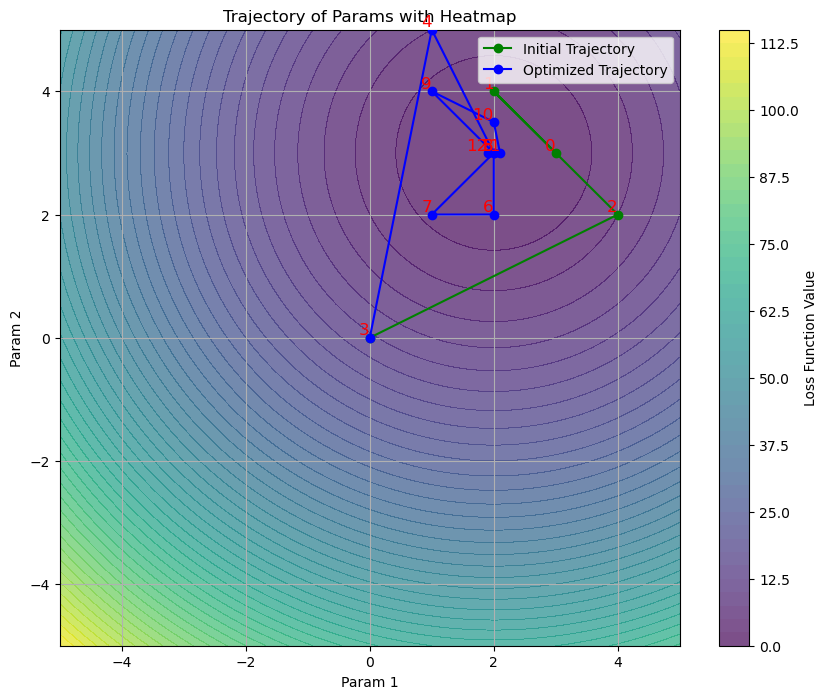

In [23]:
x_params = [item['params'][0] for item in datas]
y_params = [item['params'][1] for item in datas]
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

Z = (X - 2)**2 + (Y - 3)**2


plt.figure(figsize=(10, 8))

plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
plt.plot(x_params[:numinipoint+1], y_params[:numinipoint+1], marker='o', linestyle='-', color='g', label='Initial Trajectory', zorder=4)
plt.plot(x_params[numinipoint:], y_params[numinipoint:], marker='o', linestyle='-', color='b', label='Optimized Trajectory', zorder=4)
for i, (x, y) in enumerate(zip(x_params, y_params)):
    plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom', color='red', zorder=5)
plt.colorbar(label='Loss Function Value')
plt.xlabel('Param 1')
plt.ylabel('Param 2')
plt.title('Trajectory of Params with Heatmap')
plt.legend()

plt.grid(True)
plt.show()

The final result is:  0


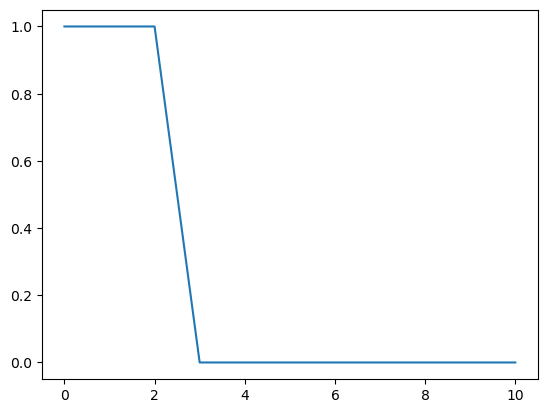

In [24]:
for i in range(len(arrloss)):
    arrloss[i] = min(arrloss[:i+1])
    
print("The final result is: ",min(arrloss))
plt.plot(arrloss)
plt.show()

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -1.0      | 3.0       | 3.0       |
| 2         | -1.0      | 2.0       | 4.0       |
| 3         | -5.0      | 4.0       | 2.0       |
| 4         | -53.54    | -3.912    | -1.311    |
| 5         | -13.0     | 5.0       | 5.0       |
| 6         | -73.0     | 5.0       | -5.0      |
| 7         | -53.0     | -5.0      | 5.0       |
| 8         | -3.149    | 0.9227    | 1.59      |
| 9         | -3.746    | 0.1116    | 3.424     |
| 10        | -0.2055   | 1.622     | 2.75      |
| 11        | -5.752    | 0.6764    | 5.0       |
| 12        | -1.462    | 2.397     | 1.858     |
| 13        | -0.02647  | 2.136     | 3.089     |


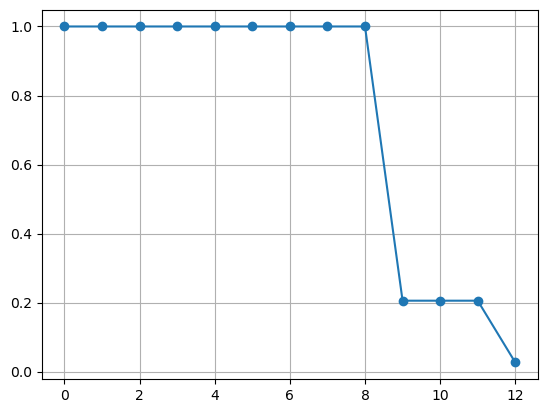

In [26]:
from bayes_opt import BayesianOptimization
pbounds = {'x': (-5, 5), 'y': (-5, 5)}
def target_function(x, y):
    return -(x-2)**2 - (y - 3)**2

optimizer = BayesianOptimization(
    f=target_function,
    pbounds=pbounds,
    random_state=1,
)

initial_points = []
for i in range(3):
    new_entry = {'x': inidatas[i][0], 'y': inidatas[i][1]}
    initial_points.append(new_entry) 

for point in initial_points:
    optimizer.probe(
        params=point,
        lazy=True
    )

# 执行优化
optimizer.maximize(
    init_points=0,
    n_iter=10,
)

target_values = [-res['target'] for res in optimizer.res]
for i in range(len(target_values)):
    target_values[i] = min(target_values[:i+1])
plt.plot(target_values, marker='o')
plt.grid(True)
plt.show()

bots: *[1, 1]*
bots: *[0, 2]*
bots: *[0, 0]*
bots: *[2, 3]*
bots: *[1, 3]*
bots: *[2, 2]*
bots: *[2, 5]*
bots: *[2, 4]*
bots: *[4, 3]*
bots: *[2, 1]*


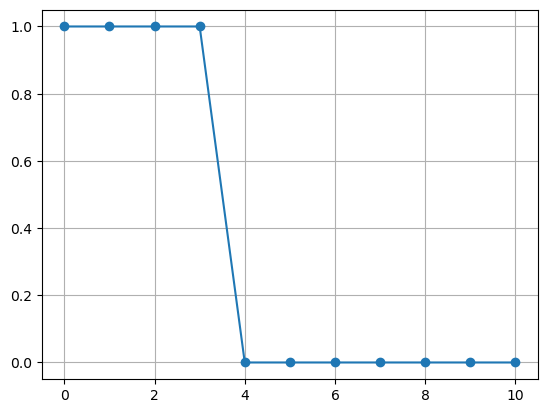

In [28]:
import LLMasOptimizer

datas = []
arrloss = [1e6]
for i in inidatas:
    loss = obj(i[0],i[1])
    new_entry = {"params": [i[0], i[1]], "loss": loss}
    arrloss[0] = min(arrloss[0],loss)
    datas.append(new_entry)
    
for i in range(10):
    point = LLMasOptimizer.Optimizer(datas)[0]
    datas.append({"params": point, "loss": obj(point[0],point[1])})
    arrloss.append(obj(point[0],point[1]))

for i in range(len(arrloss)):
    arrloss[i] = min(arrloss[:i+1])

plt.plot(arrloss, marker='o')
plt.grid(True)
plt.show()